In [4]:
import pandas as pd
titanic = pd.read_csv("./Datasets/Titanic/titanic.txt")
titanic.head()

,row.names,pclass,survived,name,age,embarked,home.dest,room,ticket,boat,sex
0,1,1st,1,"Allen, Miss Elisabeth Walton",29.0000,Southampton,"St Louis, MO",B-5,24160 L221,2,female
1,2,1st,0,"Allison, Miss Helen Loraine",2.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female
2,3,1st,0,"Allison, Mr Hudson Joshua Creighton",30.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,(135),male
3,4,1st,0,"Allison, Mrs Hudson J.C. (Bessie Waldo Daniels)",25.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female
4,5,1st,1,"Allison, Master Hudson Trevor",0.9167,Southampton,"Montreal, PQ / Chesterville, ON",C22,NaN,11,male


In [7]:
# 数据集，分离特征与预测目标

x = titanic.drop(["row.names", "name", "survived"], axis=1)
y = titanic["survived"]

x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1313 entries, 0 to 1312
Data columns (total 8 columns):
pclass       1313 non-null object
age          633 non-null float64
embarked     821 non-null object
home.dest    754 non-null object
room         77 non-null object
ticket       69 non-null object
boat         347 non-null object
sex          1313 non-null object
dtypes: float64(1), object(7)
memory usage: 82.1+ KB


In [9]:
# 处理缺失值

x["age"].fillna(x["age"].mean(), inplace=True)
x.fillna("UNKNOWN", inplace=True)

x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1313 entries, 0 to 1312
Data columns (total 8 columns):
pclass       1313 non-null object
age          1313 non-null float64
embarked     1313 non-null object
home.dest    1313 non-null object
room         1313 non-null object
ticket       1313 non-null object
boat         1313 non-null object
sex          1313 non-null object
dtypes: float64(1), object(7)
memory usage: 82.1+ KB


In [10]:
# 分割数据

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=33)

In [15]:
# 特征抽取

from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer()
x_train = vec.fit_transform(x_train.to_dict(orient="record"))
x_test = vec.transform(x_test.to_dict(orient="record"))

print(len(vec.feature_names_))

474


In [19]:
# 所有特征，决策树模型

from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(criterion="entropy")
dt.fit(x_train, y_train)
dt.score(x_test, y_test)

0.8206686930091185

In [23]:
# 筛选前20%的重要特征，决策树模型

from sklearn import feature_selection
fs = feature_selection.SelectPercentile(feature_selection.chi2, percentile=20) # 定死前20%
x_train_fs = fs.fit_transform(x_train, y_train)
x_test_fs = fs.transform(x_test)

dt.fit(x_train_fs, y_train)
dt.score(x_test_fs, y_test)



0.8267477203647416

In [37]:
# 交叉验证，确定应该使用前百分之多少的重要特征

from sklearn import feature_selection
from sklearn.model_selection import cross_val_score
import numpy as np

percentiles = range(1,100,2)
results = []
for i in percentiles:
    fs = feature_selection.SelectPercentile(feature_selection.chi2, percentile=i)
    x_train_fs = fs.fit_transform(x_train, y_train)
    scores = cross_val_score(dt, x_train_fs, y_train, cv=5)
    results = np.append(results, scores.mean())
print(results)

opt = np.where(results==results.max())[0][0]  # max=0.88622964
print("Optimal number of feature ", percentiles[opt])

[0.85063904 0.85673057 0.87501546 0.88622964 0.8598021  0.87099567
 0.87304679 0.87404659 0.86792414 0.86996496 0.86895485 0.86690373
 0.87302618 0.86083282 0.86490414 0.8628221  0.86589363 0.86587302
 0.86385281 0.86591424 0.86894455 0.8608122  0.86794475 0.86488353
 0.86590394 0.86895485 0.86591424 0.86895485 0.86894455 0.86689342
 0.86487322 0.86894455 0.87097506 0.87198516 0.87197485 0.86792414
 0.86488353 0.87504638 0.8638322  0.87199546 0.86997526 0.86690373
 0.86184292 0.861812   0.8608122  0.86183261 0.86184292 0.8608019
 0.86083282 0.85371058]
Optimal number of feature  7


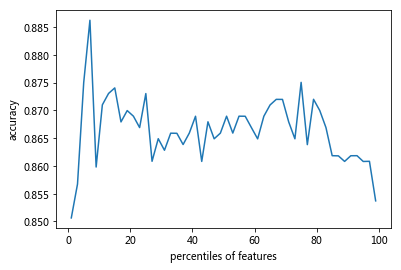

In [40]:
import pylab as pl
pl.plot(percentiles, results)
pl.xlabel("percentiles of features")
pl.ylabel("accuracy")
pl.show()

In [41]:
# 使用交叉验证得到的最佳结果，决策树模型

from sklearn import feature_selection
fs = feature_selection.SelectPercentile(feature_selection.chi2, percentile=7) # 交叉验证得，使用前7%的重要特征效果最好
x_train_fs = fs.fit_transform(x_train, y_train)
x_test_fs = fs.transform(x_test)

dt.fit(x_train_fs, y_train)
dt.score(x_test_fs, y_test)

0.8541033434650456